In [1]:
import scipy.sparse.linalg as LA
from scipy import sparse
import matplotlib.pylab as plt

import py_plantbox as pb
from rb_tools import *

import xylem_flux 

import timeit

import numpy as np
from scipy.integrate import odeint



# Simulate a root system
name = "morning_glory_7m"
plant = pb.Plant()
#sca = pb.Organ.getScalar('organtype')
plant.openXML(name)






plant.initialize()
ana = pb.SegmentAnalyser(plant)

for i in range (0,280):
    plant.simulate(i)
# for i in range(0,7):
#     plant.simulate(1) 



#seg = np.vstack((seg,lseg))
# print("number of root segments",len(rseg))
# print("number of shoot segments",len(sseg))
# print("number of segments",len(seg))

#rootnodes = v2a(sca('organtype'))

#print(rseg)
#print(sseg)
#print(lseg)
#print(sseg[1])

#print(len(nodes))
#print(len(rseg))
#print(len(lseg))



plant.write("../results/morning_glory_7m1.vtp",15)

In [2]:

nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(2)) # root system segments
sseg = seg2a(plant.getSegments(4)) # root system segments
seg = np.vstack((sseg,rseg))
# Adjacency matrix
A = sparse.coo_matrix((np.ones(seg.shape[0]),(seg[:,0],seg[:,1]))) 

# Parameters for flux model
rs_Kr = np.array([ 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-10, 2.e-11, 2.e-11 ]) # s/m; root hydraulic radial conductivity per root type 
rs_Kz = np.array([ 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5.e-14, 5.e-14 ]) # m2*s; root hydraulic axial conductivity per root type 

soil_psi = -700 # static soil pressure J kg^-1

rho = 1e3 # kg / m^3      
g = 1.e-3*9.8065 # m / s^2   

pot_trans = np.array([-1.15741e-10]) # # m^3 s^-1 potential transpiration

# Conversions
plant_ana = pb.SegmentAnalyser(plant) 
radius = v2a(plant_ana.getScalar("radius"))/100. # convert from cm to m
type = v2a(plant_ana.getScalar("subtype"))
kr = np.array(list(map(lambda t: rs_Kr[int(t)-1], type))) # convert from 'per type' to 'per segment'
kr.resize((kr.shape[0],1))
kz = np.array(list(map(lambda t: rs_Kz[int(t)-1], type)))     
kz.resize((kz.shape[0],1))          

print(radius)
# glue together shoot and root segments
shoot1 = np.ones((sseg.shape[0],1))                    
shoot0 = np.ones((sseg.shape[0],1))
radius = np.vstack((shoot1,radius))
kr =  np.vstack((shoot0,kr))
kz =  np.vstack((shoot1,kz))  
            
# Call back function for soil potential
soil = lambda x,y,z : soil_psi

# Calculate fluxes within the root system
Q, b = xylem_flux.linear_system(seg, nodes, radius, kr, kz, rho, g, soil)
# plt.spy(Q)
# plt.show()
Q, b = xylem_flux.bc_neumann(Q, b, np.array([0]), np.array([pot_trans]))


start = timeit.default_timer()
x = LA.spsolve(Q, b, use_umfpack = True) # direct
stop = timeit.default_timer()
print ("linear system solved in", stop - start, " s") 
      
# Save results into vtp 
segP = nodes2seg(nodes,seg,x)# save vtp 
axial_flux = xylem_flux.axial_flux(x, seg, nodes, kz, rho, g)
radial_flux = xylem_flux.radial_flux(x, seg, nodes, radius, kr, soil)
net_flux = axial_flux+radial_flux

plant_ana.addUserData(a2v(segP[sseg.shape[0]:]),"pressure")
plant_ana.addUserData(a2v(axial_flux[sseg.shape[0]:]),"axial_flux")
plant_ana.addUserData(a2v(radial_flux[sseg.shape[0]:]),"radial_flux")
plant_ana.addUserData(a2v(net_flux[sseg.shape[0]:]),"net_flux")

plant_ana.write("../results/morning_glory_7m_water.vtp")

[[0.00191013]
 [0.00191013]
 [0.00191013]
 [0.00191013]
 [0.00191013]
 [0.00191013]
 [0.00191013]
 [0.00191013]
 [0.0001241 ]
 [0.00013533]
 [0.00010403]
 [0.00011659]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.003     ]
 [0.00

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [3]:
# Create graph
nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
rseg = seg2a(plant.getSegments(15)) # root system segments
sseg = seg2a(plant.getSegments(4)) # strm system segments
lseg = v2ai(plant.getNodesOrganType())


plant_ana = pb.SegmentAnalyser(plant) 

nodes = vv2a(plant.getNodes())/100 # convert from cm to m 
node_connection = seg2a(plant.getSegments(15)) # plant segments
#sseg = seg2a(plant.getSegments(4)) #
node_organtype = v2ai(plant.getNodesOrganType())


nodes_with_organtype = np.column_stack([node_connection, node_organtype]) #make the node has organtype, to know the source sink relation

node_connection1, node_connection2 = np.split(node_connection.T,2)

node_connection1 = np.row_stack([node_connection1, node_organtype])
node_connection2 = np.row_stack([node_connection2, node_organtype])

nodes_organtype = np.column_stack([node_connection1,node_connection2])
_, indices = np.unique(nodes_organtype.T[:,0], return_index=True)
nodes_organtype = nodes_organtype.T[indices,:]
nodes_cor = np.column_stack([nodes_organtype, nodes])


#print(nodes_organtype)
#print(node_connection2)
#print(nodes_with_organtype)   
print(node_connection)

unq, unq_idx, unq_cnt = np.unique(node_connection, return_inverse=True, return_counts=True)
#print(unq) 

#print(unq_cnt) 

#print(len(nodes))
#print(len(unq))
 
#print(len(unq_cnt))
#print(len(node_connection))

#type = v2a(plant.getScalar(15,"subtype"))
#otype = v2a(plant.getScalar(15,"organtype"))
#print(otype)
#print(len(otype))


nodes_organtype = np.column_stack((nodes_organtype,unq_cnt ))
nodes_organtype.astype(np.int_)

node_connection.astype(np.int_)
print(len(node_connection))
print(len(nodes_organtype))
print(nodes_organtype)
print(node_connection)



stem_nodes = nodes_organtype[(nodes_organtype[:,1]== 8)|(nodes_organtype[:,1]== 4)][:,0]
index_stem= list(range(1, len(stem_nodes)+1))
for i in range(len(stem_nodes)):
    index_stem[i] = np.where( node_connection[:,1] == stem_nodes[i])

for i in range(len(index_stem)-1):
    node_connection[index_stem[i+1][0][0]]=node_connection[index_stem[i+1][0][0]][::-1]
node_connection
index_stem

[[  0   2]
 [  2   4]
 [  4  11]
 [ 11  24]
 [ 24  42]
 [ 42  43]
 [ 43  70]
 [ 70 120]
 [  2   3]
 [ 11  23]
 [ 42  68]
 [ 43  69]
 [  1   5]
 [  5   6]
 [  6   7]
 [  7   8]
 [  8   9]
 [  9  10]
 [ 10  12]
 [ 12  13]
 [ 13  14]
 [ 14  15]
 [ 15  16]
 [ 16  17]
 [ 17  18]
 [ 18  19]
 [ 19  20]
 [ 20  21]
 [ 21  22]
 [ 22  25]
 [ 25  26]
 [ 26  27]
 [ 27  28]
 [ 28  29]
 [ 29  30]
 [ 30  31]
 [ 31  32]
 [ 32  33]
 [ 33  34]
 [ 34  35]
 [ 35  37]
 [ 37  38]
 [ 38  39]
 [ 39  40]
 [ 40  41]
 [ 41  46]
 [ 46  47]
 [ 47  48]
 [ 48  49]
 [ 49  50]
 [ 50  51]
 [ 51  52]
 [ 52  55]
 [ 55  56]
 [ 56  57]
 [ 57  58]
 [ 58  59]
 [ 59  60]
 [ 60  61]
 [ 61  62]
 [ 62  64]
 [ 64  65]
 [ 65  66]
 [ 66  67]
 [ 67  74]
 [ 74  75]
 [ 75  76]
 [ 76  77]
 [ 77  78]
 [ 78  79]
 [ 79  80]
 [ 80  81]
 [ 81  84]
 [ 84  85]
 [ 85  86]
 [ 86  87]
 [ 87  88]
 [ 88  89]
 [ 89  90]
 [ 90  91]
 [ 91  92]
 [ 92  93]
 [ 93  95]
 [ 95  96]
 [ 96  99]
 [ 99 100]
 [100 101]
 [101 102]
 [102 103]
 [103 104]
 [104 105]

[(array([], dtype=int64),),
 (array([12]),),
 (array([13]),),
 (array([14]),),
 (array([15]),),
 (array([16]),),
 (array([17]),),
 (array([18]),),
 (array([19]),),
 (array([20]),),
 (array([21]),),
 (array([22]),),
 (array([23]),),
 (array([24]),),
 (array([25]),),
 (array([26]),),
 (array([27]),),
 (array([28]),),
 (array([29]),),
 (array([30]),),
 (array([31]),),
 (array([32]),),
 (array([33]),),
 (array([34]),),
 (array([35]),),
 (array([36]),),
 (array([37]),),
 (array([38]),),
 (array([39]),),
 (array([174]),),
 (array([40]),),
 (array([41]),),
 (array([42]),),
 (array([43]),),
 (array([44]),),
 (array([175]),),
 (array([176]),),
 (array([45]),),
 (array([46]),),
 (array([47]),),
 (array([48]),),
 (array([49]),),
 (array([50]),),
 (array([51]),),
 (array([177]),),
 (array([178]),),
 (array([52]),),
 (array([53]),),
 (array([54]),),
 (array([55]),),
 (array([56]),),
 (array([57]),),
 (array([58]),),
 (array([59]),),
 (array([180]),),
 (array([60]),),
 (array([61]),),
 (array([62]),

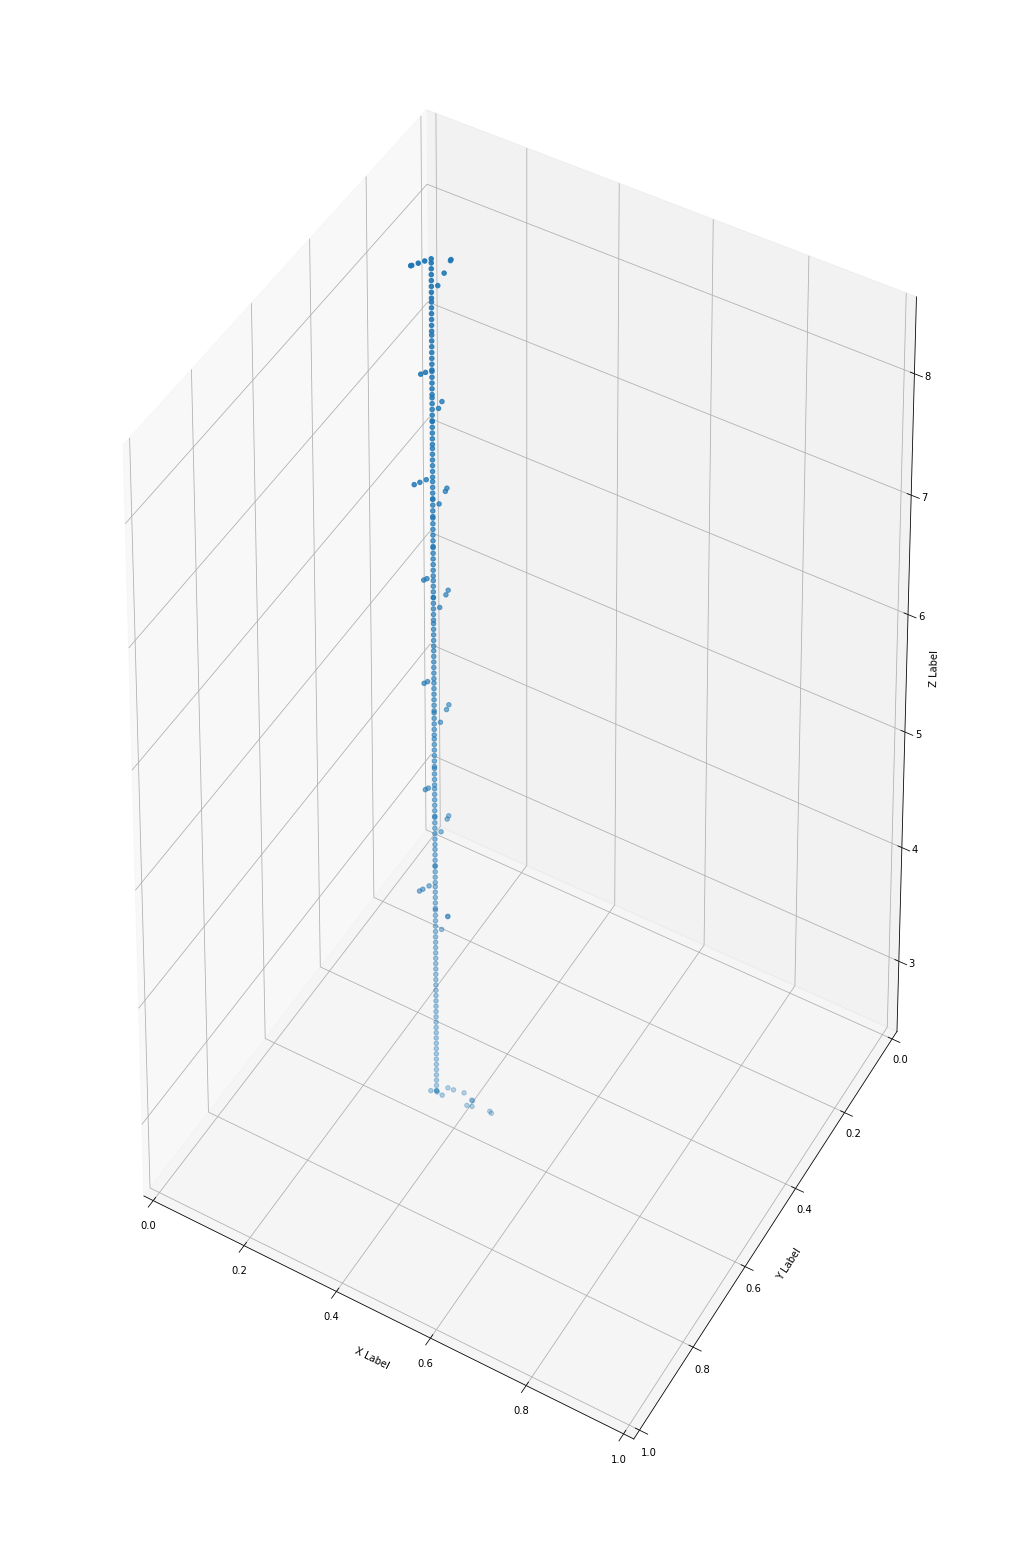

In [6]:
nodes_cor = np.column_stack([nodes_organtype, nodes])

plt.rcParams['figure.figsize'] = [18, 28]


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =nodes_cor[:,3]
y =nodes_cor[:,4]
z =nodes_cor[:,5]



#for i in range(len(nodes_cor)):
#    ax.plot([x[i]], [y[i]], [z[i]], marker='${}$'.format(nodes_cor[i,1]),
#            markersize=12, color='black')


ax.scatter(x, y, z)
#ax.scatter([x[715]], [y[715]], [z[715]], c='r', s=99)
#ax.scatter([x[860]], [y[860]], [z[860]], c='g', s=99)
#ax.scatter([x[627]], [y[627]], [z[627]], c='g', s=99)


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_xlim3d(0, 1)
ax.set_ylim3d(1,0)
ax.set_zlim3d(2.5,8.5)
plt.show()

In [6]:
# file-output.py



Nt = len(nodes)-1
Nc = len(node_connection)

#condition = ==0
#print(nodes_organtype[:,0])
nodes_organtype[1,2] =2
nodes_organtype[1,1] =1
node_connection[0,0] =1

N1L_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & ((nodes_organtype[:,1] ==8)|(nodes_organtype[:,1] ==4)  ) & (nodes_organtype[:,2] ==1 )]

N1L_c_nd = list(range(1, len(N1L_node)+1))
N1L_conn = list(range(1, len(N1L_node)+1))
for i in range(len(N1L_node)):
    N1L_c_nd[i] = node_connection[(node_connection[:,0] == N1L_node[i][0])]
    N1L_conn[i] = np.where( node_connection[:,1] == N1L_c_nd[i][0,1])[0]


N1R_node = nodes_organtype[(nodes_organtype[:,0] >2 ) & (nodes_organtype[:,1] ==2 ) & (nodes_organtype[:,2] ==1 )]
N1R_c_nd = list(range(1, len(N1R_node)+1))
N1R_conn = list(range(1, len(N1R_node)+1))
for i in range(len(N1R_node)):
    N1R_c_nd[i] = node_connection[(node_connection[:,1] == N1R_node[i][0])]
    N1R_conn[i] = np.where( node_connection[:,1] == N1R_c_nd[i][0,1])[0]
N1R_r_abs = 1e-025

N2_node = nodes_organtype[ (nodes_organtype[:,2] ==2 )]

# #print(N2_node)
# N2_c_nd_1 = list(range(1, len(N2_node)+1))
# N2_conn_1 = list(range(1, len(N2_node)+1))
# for i in range(len(N2_node)):
#     if N2_node[i,1] == 2 or N2_node[i,1] == 1:
#         N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
#         N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]
#     else:
#         N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
#         N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]

# #temp= N2_c_nd_1[0]
# #temp=temp[::-1] 
# #print(temp )
# N2_c_nd_2 = list(range(1, len(N2_node)+1))
# N2_conn_2 = list(range(1, len(N2_node)+1))

# for i in range(len(N2_node)):
#     if N2_node[i,1] == 2 or N2_node[i,1] == 1:
#         N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
#     else:
#         N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
# #N2_c_nd_2[0] = np.array([temp]) 
# #print(N2_c_nd_2)
# for i in range(len(N2_node)):
#     N2_conn_2[i] = np.where( node_connection[:,1] == N2_c_nd_2[i][0][0])[0]

# N2_conn_2[0]=[0-(np.where( node_connection[:,0] == 1))[0][1]-2]


################## Nodes With 2 Connections #########################
N2_c_nd_1 = list(range(1, len(N2_node)+1))
N2_conn_1 = list(range(1, len(N2_node)+1))
for i in range(len(N2_node)):
    N2_c_nd_1[i] = node_connection[(node_connection[:,0] == N2_node[i,0])]
    N2_conn_1[i] = np.where( node_connection[:,0] == N2_c_nd_1[i][0,0])[0]


#temp= N2_c_nd_1[0]
#temp=temp[::-1] 
#print(temp )

N2_c_nd_2 = list(range(1, len(N2_node)+1))
N2_conn_2 = list(range(1, len(N2_node)+1))

for i in range(len(N2_node)):
    N2_c_nd_2[i] = node_connection[(node_connection[:,1] == N2_node[i,0])]
    N2_conn_2[i] = np.where( node_connection[:,1] == N2_c_nd_2[i][0][1])[0]

    

################## Nodes With 3 Connections #########################
N3_node = nodes_organtype[ (nodes_organtype[:,2] ==3 )]
print(N3_node)

N3_c_nd_1 = list(range(1, len(N3_node)+1))
N3_conn_1 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_1[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][0][0]
        N3_conn_1[i] = 0-np.where( node_connection[:,0] == N3_c_nd_1[i])[0][0]-1
    else:
        N3_c_nd_1[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][0][1]
        N3_conn_1[i] = np.where( node_connection[:,1] == N3_c_nd_1[i])[0][0]+1

N3_c_nd_2 = list(range(1, len(N3_node)+1))
N3_conn_2 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_2[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][0][1]
        N3_conn_2[i] = np.where( node_connection[:,1] == N3_c_nd_2[i])[0][0]+1
    else:
        N3_c_nd_2[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][0][0]
        N3_conn_2[i] = 0-np.where( node_connection[:,0] == N3_c_nd_2[i])[0][0]-1

N3_c_nd_3 = list(range(1, len(N3_node)+1))
N3_conn_3 = list(range(1, len(N3_node)+1))
for i in range(len(N3_node)):
    if N3_node[i,1] == 2 or N2_node[i,1] == 1:
        N3_c_nd_3[i] = node_connection[(node_connection[:,0] == N3_node[i,0])][1][1]
        N3_conn_3[i] = np.where( node_connection[:,1] == N3_c_nd_3[i])[0][0]+1
    else:
        N3_c_nd_3[i] = node_connection[(node_connection[:,1] == N3_node[i,0])][1][0]
        N3_conn_3[i] = 0-np.where( node_connection[:,0] == N3_c_nd_3[i])[0][0]-1
# for i in range(len(N3_node)):
#     print(N3_c_nd_3[i][1,1])
#for i in range(len(N3_node)):
#    print(N3_conn_3[i][0]+1)
# N3_node = nodes_organtype[ (nodes_organtype[:,2] ==3 )]
# #print(N3_node)

# N3_c_nd_1 = list(range(1, len(N3_node)+1))
# N3_conn_1 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_1[i] = node_connection[(node_connection[:,1] == N3_node[i,0])]
#     N3_conn_1[i] = np.where( node_connection[:,0] == N3_c_nd_1[i][0,0])[0]

# #print(len(N3_c_nd_1))
# #print(len(N3_conn_1))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_1[i][0,0])
# #for i in range(len(N3_node)):
# #    print(N3_conn_1[i][0]+1)
    
    
# N3_c_nd_2 = list(range(1, len(N3_node)+1))
# N3_conn_2 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_2[i] = node_connection[(node_connection[:,0] == N3_node[i,0])]
#     N3_conn_2[i] = np.where( node_connection[:,1] == N3_c_nd_2[i][0,1])[0]

# #print(len(N3_c_nd_2))
# #print(len(N3_conn_2))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_2[i][0,1])
# #for i in range(len(N3_node)):
# #    print(N3_conn_2[i][0]+1)
    
# N3_c_nd_3 = list(range(1, len(N3_node)+1))
# N3_conn_3 = list(range(1, len(N3_node)+1))
# for i in range(len(N3_node)):
#     N3_c_nd_3[i] = node_connection[(node_connection[:,0] == N3_node[i,0])]
#     N3_conn_3[i] = np.where( node_connection[:,1] == N3_c_nd_3[i][1,1])[0]

# #print(N3_c_nd_3)
# #print(len(N3_conn_3))
# #for i in range(len(N3_node)):
# #    print(N3_c_nd_3[i][1,1])
# #for i in range(len(N3_node)):
# #    print(N3_conn_3[i][0]+1)

N4_node = nodes_organtype[ (nodes_organtype[:,2] ==4 )]
#print(N4_node)

N4_c_nd_1 = list(range(1, len(N4_node)+1))
N4_conn_1 = list(range(1, len(N4_node)+1))
for i in range(len(N4_node)):
    N4_c_nd_1[i] = node_connection[(node_connection[:,0] == N4_node[i,0])][0][1]
    N4_conn_1[i] = np.where( node_connection[:,1] == N4_c_nd_1[i])[0][0]+1

print(N4_c_nd_1)
print(N4_conn_1)
#for i in range(len(N4_node)):
#    print(N4_c_nd_1[i])
#for i in range(len(N4_node)):
#    print(N4_conn_1[i][0]+1)
    
    
N4_c_nd_2 = list(range(1, len(N4_node)+1))
N4_conn_2 = list(range(1, len(N4_node)+1))
N4_conn_3 = list(range(1, len(N4_node)+1))
N4_conn_4 = list(range(1, len(N4_node)+1))
for i in range(len(N4_node)):
    N4_c_nd_2[i] = node_connection[(node_connection[:,1] == N4_node[i,0])]
    N4_conn_2[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][0][0])[0]
    N4_conn_3[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][1][0])[0]
    N4_conn_4[i] = np.where( node_connection[:,0] == N4_c_nd_2[i][2][0])[0]

# print(N4_c_nd_2[0][0][1])
# print(N4_c_nd_2[0][1][1])    
# print(N4_c_nd_2[0][2][1]) 

# print(N4_c_nd_2[0][0][0])
# print(N4_c_nd_2) 
# print(N4_conn_2) 
# print(N4_conn_3) 
# print(N4_conn_4) 










#'******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n'
#initialization of the parameters
kML = np.zeros(len(nodes_organtype))
vML = np.zeros(len(nodes_organtype))
kMU = np.zeros(len(nodes_organtype))
vMU = np.zeros(len(nodes_organtype))
kMParMb = np.zeros(len(nodes_organtype))
vMParMb = np.zeros(len(nodes_organtype))
kM = np.zeros(len(nodes_organtype))
Vmax = np.zeros(len(nodes_organtype))
C_targ = np.zeros(len(nodes_organtype))
kHyd = np.zeros(len(nodes_organtype))
k1 = np.zeros(len(nodes_organtype))
k2 = np.zeros(len(nodes_organtype))
k3 = np.zeros(len(nodes_organtype))
StructC = np.zeros(len(nodes_organtype))
vol_ST = np.zeros(len(nodes_organtype))
volPhlApo = np.zeros(len(nodes_organtype))
volParApo = np.zeros(len(nodes_organtype))
k_Lockhart = np.zeros(len(nodes_organtype))
P_thr = np.zeros(len(nodes_organtype))
vol_Sympl_max = np.zeros(len(nodes_organtype))

r_Xyl = np.full(len(nodes_organtype), 1e-025)
r_ST = np.full(len(nodes_organtype), 1405.03/1000)
r_Trsv = np.full(len(nodes_organtype), 100)
r_PhlMb = np.full(len(nodes_organtype), 135.785)
r_ParMb = np.full(len(nodes_organtype), 1e+025)
r_Apo = np.full(len(nodes_organtype), 1e+025)
r_Sympl = np.full(len(nodes_organtype), 1e+025)




for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
        kML[i]     =  1e-100
        vML[i]        = 0.000143136      #different in source, sink or connection of piafmunch2
        kMU[i]        = 10e-100     #different in source, sink or connection of piafmunch2
        vMU[i]        = 0      #different in source, sink or connection of piafmunch2
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     = 0.17      #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0
        k3[i]         = 0
        StructC[i]    = 0      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 8.83573e-05
        volPhlApo[i]  = 8.83573e-05
        volParApo[i]  = 8.83573e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018
    elif nodes_organtype[i,0]>0 and nodes_organtype[i,1]==2 and nodes_organtype[i,2]==1:   #all the sinks  
        kML[i]     =  1e-100
        vML[i]        = 0      #different in source, sink or connection of piafmunch2
        kMU[i]        =   1e+99      #different in source, sink or connection of piafmunch2
        vMU[i]        = 2.82627e+95      #different in source, sink or connection of piafmunch2
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     =     0.1     #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0
        k3[i]         = 0
        StructC[i]    = 1      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 8.83573e-05
        volPhlApo[i]  = 8.83573e-05
        volParApo[i]  = 8.83573e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018        
    elif nodes_organtype[i,2]!=1:
        kML[i]     =  1e-100
        vML[i]        = 0      #different in source, sink or connection of piafmunch2
        kMU[i]        = 1e-100      #different in source, sink or connection of piafmunch2
        vMU[i]        = 0      #different in source, sink or connection of piafmunch2
        kMParMb[i]    = 1
        vMParMb[i]    = 0
        kM[i]         = 1e-100
        Vmax[i]       = 0
        C_targ[i]     = 0.1      #different in source, sink or connection of piafmunch2
        kHyd[i]       = 0
        k1[i]         = 0
        k2[i]         = 0
        k3[i]         = 0
        StructC[i]    = 1      #different in source, sink or connection of piafmunch2
        vol_ST[i]     = 8.83573e-05
        volPhlApo[i]  = 8.83573e-05
        volParApo[i]  = 8.83573e-05
        k_Lockhart[i] = 0
        P_thr[i]      = 1
        vol_Sympl_max[i] = 0.00018



#'******** INITIAL VALUES *********\n'
#initialization of the parameters
Q_ST = np.full(len(nodes_organtype), 0)
Q_Sympl = np.full(len(nodes_organtype), 4.4e-006)
Starch = np.full(len(nodes_organtype), 1)
Q_PhlApo = np.full(len(nodes_organtype), 4.4e-006)
Q_ParApo = np.full(len(nodes_organtype), 4.4e-006)
Tr_Q_ST = np.full(len(nodes_organtype), 0)
Tr_Q_Sympl = np.full(len(nodes_organtype), 4.4e-006)
Tr_Starch = np.full(len(nodes_organtype), 1)
Tr_Q_PhlApo = np.full(len(nodes_organtype), 0)
Tr_Q_ParApo = np.full(len(nodes_organtype), 0)
vol_Sympl = np.full(len(nodes_organtype), 8.83573e-005)

#******** SIMULATION SOLVING PARAMETERS *********


#'******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n'
#initialization of the parameters

Q_ST_Abs = np.full(len(nodes_organtype), 8.83573e-012)
Q_Sympl_Abs = np.full(len(nodes_organtype), 1e-007)
Starch_Abs = np.full(len(nodes_organtype), 1e-007)
Q_PhlApo_Abs = np.full(len(nodes_organtype), 8.83573e-012)
Q_ParApo_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Q_ST_Abs = np.full(len(nodes_organtype), 8.83573e-012)
Tr_Q_Sympl_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Starch_Abs = np.full(len(nodes_organtype), 1e-007)
Tr_Q_PhlApo_Abs = np.full(len(nodes_organtype), 8.83573e-012)
Tr_Q_ParApo_Abs = np.full(len(nodes_organtype), 1e-007)
vol_Sympl_Abs = np.full(len(nodes_organtype), 8.83573e-012)



for i in range(len(nodes_organtype)): #given different value based on whether it is source, sink or connection
    if (nodes_organtype[i,1] == 8 or nodes_organtype[i,1] == 4) and nodes_organtype[i,2] == 1: #all the sources       
        Q_ST_Abs[i] =  1e-015
        Q_Sympl_Abs[i] =  1e-015
        Starch_Abs[i] =  1e-012
        Q_PhlApo_Abs[i] =  1e-015
        Q_ParApo_Abs[i] =  1e-015
        Tr_Q_ST_Abs[i] =  1e-012
        Tr_Q_Sympl_Abs[i] =  1e-012
        Tr_Starch_Abs[i] =  1e-012
        Tr_Q_PhlApo_Abs[i] =  1e-015
        Tr_Q_ParApo_Abs[i] =  1e-015
        vol_Sympl_Abs[i] = 1e-012













f = open('PiafMunch2_python_test_mg.ini','w')
f.write('******** DESCRIPTION OF ARCHITECTURE *********\n\n')

f.write("Total number of Nodes : {0} = {1}\n".format('Nt', Nt))
f.write("number of Internode Connections : {0} = {1}\n\n".format('Nc', Nc))

f.write("Nodes Of Connectivity Order 1, Transpiring Leaf Ends : {0} = {1}\n".format('N1L', len(N1L_node)))
f.write("{:s}  {:s}  {:s}\n".format('node#','c.node','conn.#'))
for i in range(len(N1L_node)):
    f.write("{:d}  {:d}  {:d}\n\n".format(N1L_node[i][0],N1L_c_nd[i][0,1],(N1L_conn[i][0]+1)))





f.write("Nodes Of Connectivity Order 1, Absorbing Root Ends : {0} = {1}\n\n".format('N1R', len(N1R_node)))
f.write("{:s}  {:s}  {:s}  {:s}\n".format('node#','c.node','conn.#','r_abs'))
for i in range(len(N1R_node)):
    f.write("{:d}  {:d}  {:d} {:e}\n\n".format(N1R_node[i][0], N1R_c_nd[i][0,0],0- N1R_conn[i][0]-1, 1e-025))

f.write('Nodes Of Connectivity Order 2 :  {0} = {1}\n\n' .format('N2', len(N2_node) ))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2'))
for i in range(len(N2_node)):
    f.write("{:d}  {:d}  {:d} {:d} {:d} \n".format(N2_node[i][0],N2_c_nd_1[i][0,1],N2_conn_1[i][0]+1,N2_c_nd_2[i][0,0],0 -N2_conn_2[i][0]-1))    
f.write('\n')

f.write("Nodes Of Connectivity Order 3 :  {0} = {1}\n".format('N3', np.count_nonzero(unq_cnt == 3)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3'))
for i in range(len(N3_node)):
    f.write("{:d}  {:d}  {:d} {:d} {:d} {:d} {:d}\n".format(N3_node[i][0],N3_c_nd_1[i],N3_conn_1[i],N3_c_nd_2[i],N3_conn_2[i],N3_c_nd_3[i],N3_conn_3[i]))    
f.write('\n')




f.write("Nodes Of Connectivity Order 4 :  {0} = {1}\n\n".format('N4', np.count_nonzero(unq_cnt == 4)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4'))

for i in range(len(N4_node)):
    f.write("{:d}  {:d}  {:d} {:d} {:d} {:d} {:d} {:d} {:d}\n".format(N4_node[i][0],N4_c_nd_1[i],N4_conn_1[i],N4_c_nd_2[i][0][0],0-N4_conn_2[i][0]-1,N4_c_nd_2[i][1][0],0-N4_conn_3[i][0]-1,N4_c_nd_2[i][2][0],0-N4_conn_4[i][0]-1))    
f.write('\n')



f.write("Nodes Of Connectivity Order 5 :  {0} = {1}\n\n".format('N5', np.count_nonzero(unq_cnt == 5)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5'))
f.write("Nodes Of Connectivity Order 6 :  {0} = {1}\n".format('N6', np.count_nonzero(unq_cnt == 6)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6'))
f.write("Nodes Of Connectivity Order 7 :  {0} = {1}\n".format('N7', np.count_nonzero(unq_cnt == 7)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6','c.nd.7','conn.7'))
f.write("Nodes Of Connectivity Order 8 :  {0} = {1}\n".format('N8', np.count_nonzero(unq_cnt == 8)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n\n".format('node#','c.nd.1','conn.1','c.nd.2','conn.2','c.nd.3','conn.3','c.nd.4','conn.4','c.nd.5','conn.5','c.nd.6','conn.6','c.nd.7','conn.7','c.nd.8','conn.8'))

f.write('******** WATER FLUX - RELATED PARAMETERS *********\n\n')
f.write("{:s}  {:s}  {:s} \n".format('T\xb0 K','visco=f(C)','NonLin.Psi+NonZeroSugarVol.'))
f.write("{:s}  {:s}  {:s} \n".format('293','true','true'))

f.write('InterNode Connections -- Axial Resistances (MPa h / ml) : Nc= {}\n' .format(len(node_connection)))
f.write("{:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','upfl.node','dnfl.node','r_Xyl','r_ST' ))
for i in range(len(node_connection)):
    f.write("{:d}  {:d}  {:d} {:e} {:e}\n".format(i+1,node_connection[i,0],node_connection[i,1],r_Xyl[i],r_ST[i]))
f.write('\n')

f.write('Individual Node : Lateral Resistances (MPa h / ml)\n')
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','r_Trsv','r_PhlMb','r_ParMb','r_Apo', 'r_Sympl' ))
for i in range(len(nodes_organtype)-1):
    f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}\n".format(nodes_organtype[i+1][0],r_Trsv[i],r_PhlMb[i],r_ParMb[i],r_Apo[i],r_Sympl[i]))
f.write('\n')


f.write('******** CARBON Lateral FLUX - RELATED PARAMETERS *********\n')    
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s}  {:s} \n".format('node#','kML(M)','vML(mmol/h)','kMU(M)','vMU(mmol/h)', 'kMParMb(M)','vMParMb(mmol/h)','kM(M)','Vmax(M/h)','C_targ(M)','kHyd(h-1)','k1(h-1)','k2','k3(h-1)','StructC','vol_ST(ml)','volPhlApo,ml','volParApo,ml','k_Lockhart','P_thr(MPa)','vol_Sympl_max,ml' ))    
for i in range(len(nodes_organtype)-1):
    f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e}\n"
    .format(nodes_organtype[i+1][0],kML[i+1], vML[i+1], kMU[i+1], vMU[i+1], kMParMb[i+1], vMParMb[i+1], kM[i+1], Vmax[i+1], C_targ[i+1], kHyd[i+1], 
    k1[i+1], k2[i+1], k3[i+1], StructC[i+1], vol_ST[i+1], volPhlApo[i+1], volParApo[i+1], k_Lockhart[i+1], P_thr[i+1], vol_Sympl_max[i+1]))
f.write('\n')



f.write('******** INITIAL VALUES  *********\n')
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s} {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','Q.ST(mmol)','Q.Sympl(mmol)','Starch','Q.PhlApo(mmol)', 'Q.ParApo(mmol)',
                                            'Tr.Q.ST(mmol)','Tr.Q.Sympl(mmol)','Tr.Starch','Tr.Q.PhlApo(mmol)', 'Tr.Q.ParApo(mmol)','vol_Sympl(ml)' ))
for i in range(len(nodes_organtype)-1):
    f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e} {:e}\n"
            .format(nodes_organtype[i+1][0], Q_ST[i+1],Q_Sympl[i+1],Starch[i+1],Q_PhlApo[i+1],Q_ParApo[i+1], 
                    Tr_Q_ST[i+1],Tr_Q_Sympl[i+1],Tr_Starch[i+1],Tr_Q_PhlApo[i+1],Tr_Q_ParApo[i+1],vol_Sympl[i+1]))
f.write('\n')    
    
f.write('******** SIMULATION SOLVING PARAMETERS *********\n')
f.write('{:s}  {:s}  {:s}   {:s}  {:s}\n'.format('StartTime','EndTime','OutputStep', 'TracerHalfLife','Rel_Tol'))
f.write('{:s}  {:s}  {:s}   {:s}  {:s}\n'.format('0', '100', '0.166667', '0.33967', '1e-007'))
f.write('\n')     

f.write('***Abs_Tols for individual  nodes ***')
f.write("{:s}  {:s}  {:s}  {:s}  {:s}  {:s} {:s}  {:s}  {:s}  {:s}  {:s}  {:s}\n".format('node#','Q.ST(mmol)','Q.Sympl(mmol)','Starch','Q.PhlApo(mmol)', 'Q.ParApo(mmol)',
                                            'Tr.Q.ST(mmol)','Tr.Q.Sympl(mmol)','Tr.Starch','Tr.Q.PhlApo(mmol)', 'Tr.Q.ParApo(mmol)','vol_Sympl(ml)' ))
for i in range(len(nodes_organtype)-1):
    f.write("{:d}  {:e}  {:e} {:e} {:e} {:e}  {:e}  {:e} {:e} {:e} {:e} {:e}\n"
            .format(nodes_organtype[i+1][0], Q_ST_Abs[i+1],Q_Sympl_Abs[i+1],Starch_Abs[i+1],Q_PhlApo_Abs[i+1],Q_ParApo_Abs[i+1], 
                    Tr_Q_ST_Abs[i+1],Tr_Q_Sympl_Abs[i+1],Tr_Starch_Abs[i+1],Tr_Q_PhlApo_Abs[i+1],Tr_Q_ParApo_Abs[i+1],vol_Sympl_Abs[i+1]))
f.write('\n')     
    
f.write('******** OUTPUT SETTINGS : INDIVIDUAL NODE - LATERAL FLUXES-RELATED VARIABLES *********\n')    
f.write('Nodes selected for plotting  : nsp = {:d}\n' .format((len(nodes_organtype))-1 ))    
for i in range(len(nodes_organtype)-1):
    f.write('{:d}\n'.format(nodes_organtype[i+1][0]))
    
f.write('individual-Node-related variables selected for plotting : nvp = 1\n')    
f.write('C_ST (mmol / ml)\n')        
#f.write('JS_PhlMb (mmol / h)\n')        
#f.write('JW_Trsv (ml / h)\n')        

   
f.write('Nodes selected for saving  : nss = {:d}\n' .format((len(nodes_organtype))-1 ))    
for i in range(len(nodes_organtype)-1):
    f.write('{:d}\n'.format(nodes_organtype[i+1][0]))
f.write('\n')    


f.write('individual-Node-related variables selected for saving : nvs = 30\n')    
f.write('''
C_ApoUpflow (mmol / ml)
C_ParApo (mmol / ml)
C_PhlApo (mmol / ml)
C_ST (mmol / ml)
C_Sympl (mmol / ml)
C_SymplUpflow (mmol / ml)
JS_Apo (mmol / h)
JS_ParMb (mmol / h)
JS_PhlMb (mmol / h)
JS_Sympl (mmol / h)
JW_Apo (ml / h)
JW_ParMb (ml / h)
JW_Sympl (ml / h)
JW_Trsv (ml / h)
P_PhlApo (MPa)
P_ST (MPa)
P_ST_dot (MPa / h)
P_Sympl (MPa)
P_Sympl_dot (MPa / h)
P_Xyl (MPa)
PsiSoil (MPa)
Psi_ParApo (MPa)
Psi_PhlApo (MPa)
Psi_ST (MPa)
Q_PhlApo (mmol)
Q_PhlApo_dot (mmol / h)
Q_Sympl_dot (mmol / h)
Transpirat (ml / h)
vol_Sympl (ml)
vol_Sympl_dot (ml / h)
StarchSyn (mmol eq. Glu / h)
Starch (mmol eq. Glu)
''')

f.write('******** OUTPUT SETTINGS : INTERNODE CONNECTION - AXIAL FLUXES-RELATED VARIABLES *********\n')  
f.write('node-to-node Fluxes selected for plotting  : fsp = {} \n' .format(len(node_connection)))
for i in range(len(node_connection)):
    f.write("{:d}\n".format((i+1)))
f.write('\n')

f.write('node-to-node-Fluxes-related variables selected for plotting : fvp = 1\n')    
#f.write('JS_ST (mmol / h)\n')        
f.write('JW_ST (ml / h)\n')        
      
 
f.write('node-to-node Fluxes selected for saving  : fss = {} \n' .format(len(node_connection)))
for i in range(len(node_connection)):
    f.write("{:d}\n".format((i+1)))
f.write('\n')

f.write('node-to-node-Fluxes-related variables selected for saving : fvs = 4\n')    
f.write('JS_ST (mmol / h)\n')        
f.write('JW_ST (ml / h)\n')  
f.write('C_Upflow (mmol / ml)\n')
f.write('JW_Xyl (ml / h)\n')  

print('out put successful')




f.close()

[[  2   2   3]
 [ 11   2   3]
 [ 25   2   3]
 [ 36   4   3]
 [ 43   2   3]
 [ 53   4   3]
 [ 72   4   3]
 [ 86   4   3]
 [101   4   3]
 [114   4   3]
 [128   4   3]
 [143   4   3]
 [156   4   3]
 [174   4   3]
 [187   4   3]
 [202   4   3]]
[]
[]
out put successful


In [6]:
import pandas as pd
path = 'PiafMunch2_python_test_mg_output.txt'
#pd.read_table(path,sep='\t')
output = pd.read_table(path,sep='\t',header=1)
JS_ST_begin = (len(node_connection)+1)*3+1
JS_ST_end = JS_ST_begin +(len(node_connection))
output.iloc[54, JS_ST_begin:JS_ST_end]
plant_ana.clearUserData()
JS_ST_0_out=output.iloc[1, JS_ST_begin:JS_ST_end]
JS_ST_0_out_array = JS_ST_0_out.values
plant_ana.addUserData(a2v(JS_ST_0_out_array),"JS_ST_0")

JS_ST_1_out=output.iloc[7, JS_ST_begin:JS_ST_end]
JS_ST_1_out_array = JS_ST_1_out.values
plant_ana.addUserData(a2v(JS_ST_1_out_array),"JS_ST_1")


JS_ST_5_out=output.iloc[30, JS_ST_begin:JS_ST_end]
JS_ST_5_out_array = JS_ST_5_out.values
plant_ana.addUserData(a2v(JS_ST_5_out_array),"JS_ST_5")

JS_ST_9_out=output.iloc[50, JS_ST_begin:JS_ST_end]
JS_ST_9_out_array = JS_ST_9_out.values
plant_ana.addUserData(a2v(JS_ST_9_out_array),"JS_ST_9")



print(len(segP[sseg.shape[0]:]))
print(len(JS_ST_1_out_array))
plant_ana.write("results/Phloem.vtp")
plant_ana.write("results/Phloem.txt")

ModuleNotFoundError: No module named 'pandas'

In [ ]:
from scipy.stats import loglaplace,chi2
from labellines import labelLine, labelLines
for i in range(0,37):
    f = plt.figure()
    n_begin = (len(node_connection)+1)*i+1
    n_end = n_begin +(len(node_connection))
    var_all = np.array(output.iloc[:,n_begin:n_end])
    x = np.array(time)
    y = np.array(var_all)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("{}th figure {} ".format(i ,output.columns[n_begin]))
    
    for i in range(len(np.transpose(y))):
        plt.plot(x,[pt[i] for pt in y],label = '{0}'.format(nodes_organtype[i+1,0]))
    #plt.legend()
    labelLines(plt.gca().get_lines(), xvals=(45, 50), zorder=0)
    plt.show()
    s =output.columns[n_begin]
    s = s.replace('/', '')
    f.savefig("{}.pdf".format(s), bbox_inches='tight')